# Рекомендательные системы

## Explicit feedback

In [ ]:
https://nijianmo.github.io/amazon/index.html#complete-data
https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/

In [ ]:
""" время в лекции часть 1 04:30 """

In [223]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.base import BaseEstimator
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Data loading

надо загрузить три разных датасета и свести в один с подробной информацией.

In [46]:
Luxury_Beauty = pd.read_csv('Luxury_Beauty.csv')

In [47]:
new_columns = ['item','user','rating','timestamp']

In [48]:
Luxury_Beauty.columns = new_columns

In [49]:
Luxury_Beauty

,item,user,rating,timestamp
0,B00004U9V2,A3HO2SQDCZIE9S,5.0,1262822400
1,B00004U9V2,A2EM03F99X3RJZ,5.0,1524009600
2,B00004U9V2,A3Z74TDRGD0HU,5.0,1524009600
3,B00004U9V2,A2UXFNW9RTL4VM,5.0,1523923200
4,B00004U9V2,AXX5G4LFF12R6,5.0,1523664000
...,...,...,...,...
574622,B01HIQEOLO,AHYJ78MVF4UQO,5.0,1489968000
574623,B01HIQEOLO,A1L2RT7KBNK02K,5.0,1477440000
574624,B01HIQEOLO,A36MLXQX9WPPW9,5.0,1475193600
574625,B01HJ2UY0W,A23DRCOMC2RIXF,1.0,1480896000


In [51]:
Luxury_Beauty['date_time'] = pd.to_datetime(Luxury_Beauty['timestamp'], unit='s').dt.date

In [52]:
Luxury_Beauty

,item,user,rating,timestamp,date_time
0,B00004U9V2,A3HO2SQDCZIE9S,5.0,1262822400,2010-01-07
1,B00004U9V2,A2EM03F99X3RJZ,5.0,1524009600,2018-04-18
2,B00004U9V2,A3Z74TDRGD0HU,5.0,1524009600,2018-04-18
3,B00004U9V2,A2UXFNW9RTL4VM,5.0,1523923200,2018-04-17
4,B00004U9V2,AXX5G4LFF12R6,5.0,1523664000,2018-04-14
...,...,...,...,...,...
574622,B01HIQEOLO,AHYJ78MVF4UQO,5.0,1489968000,2017-03-20
574623,B01HIQEOLO,A1L2RT7KBNK02K,5.0,1477440000,2016-10-26
574624,B01HIQEOLO,A36MLXQX9WPPW9,5.0,1475193600,2016-09-30
574625,B01HJ2UY0W,A23DRCOMC2RIXF,1.0,1480896000,2016-12-05


In [61]:
Luxury_Beauty['date_time'] = pd.to_datetime(Luxury_Beauty['date_time'])

array([[<AxesSubplot: title={'center': 'date_time'}>, <AxesSubplot: >]],
      dtype=object)

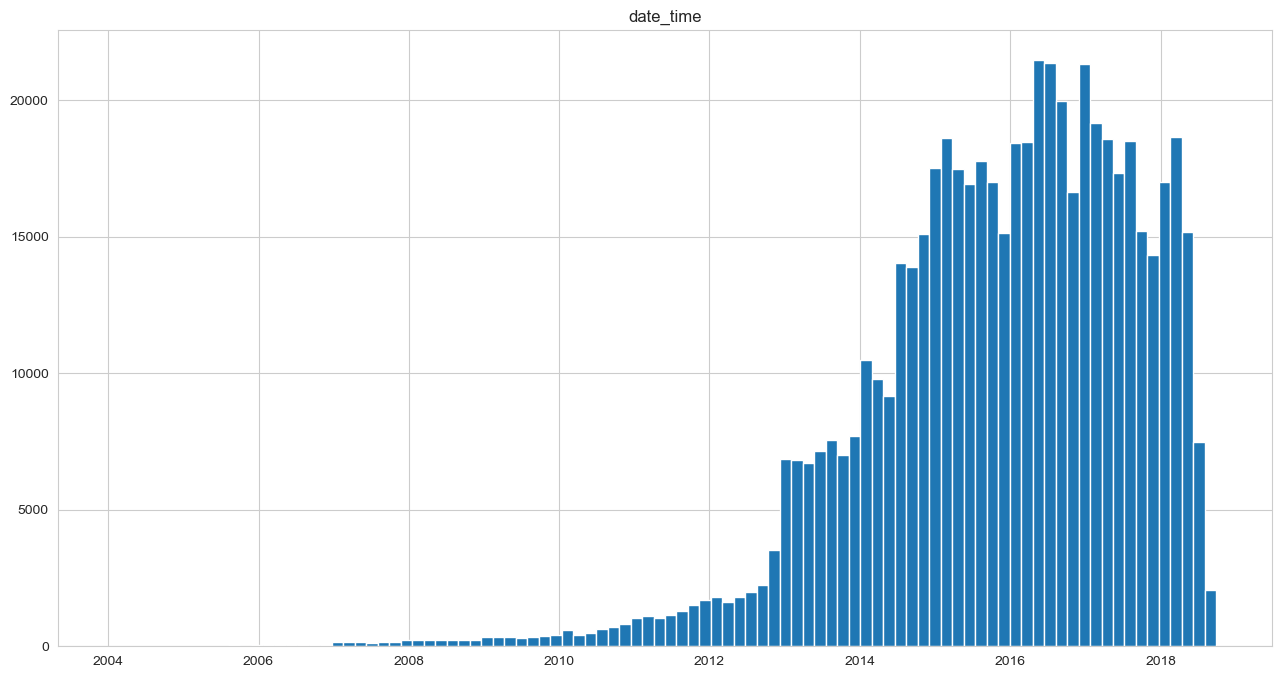

In [70]:
Luxury_Beauty[['date_time']].hist(bins=96, figsize=(36,8), layout=(1, 2))

array([[<AxesSubplot: title={'center': 'date_time'}>, <AxesSubplot: >]],
      dtype=object)

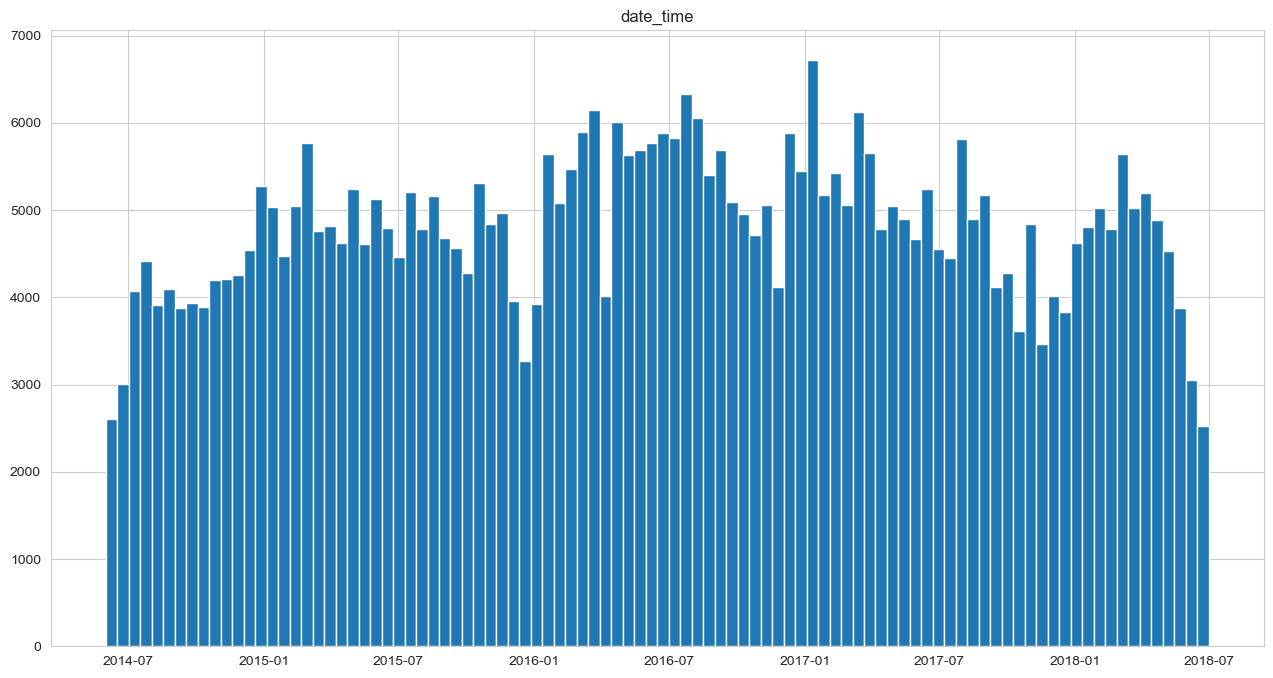

In [84]:
Luxury_Beauty[['date_time']].query('date_time >= datetime.datetime(2014, 6, 1) & date_time <= datetime.datetime(2018, 6, 30)').hist(bins=96, figsize=(36,8), layout=(1, 2))

In [400]:
Luxury_Beauty_pruned = Luxury_Beauty.query('date_time >= datetime.datetime(2006, 6, 1) & date_time <= datetime.datetime(2018, 6, 30)')

In [401]:
Luxury_Beauty_pruned

,item,user,rating,timestamp,date_time
0,B00004U9V2,A3HO2SQDCZIE9S,5.0,1262822400,2010-01-07
1,B00004U9V2,A2EM03F99X3RJZ,5.0,1524009600,2018-04-18
2,B00004U9V2,A3Z74TDRGD0HU,5.0,1524009600,2018-04-18
3,B00004U9V2,A2UXFNW9RTL4VM,5.0,1523923200,2018-04-17
4,B00004U9V2,AXX5G4LFF12R6,5.0,1523664000,2018-04-14
...,...,...,...,...,...
574622,B01HIQEOLO,AHYJ78MVF4UQO,5.0,1489968000,2017-03-20
574623,B01HIQEOLO,A1L2RT7KBNK02K,5.0,1477440000,2016-10-26
574624,B01HIQEOLO,A36MLXQX9WPPW9,5.0,1475193600,2016-09-30
574625,B01HJ2UY0W,A23DRCOMC2RIXF,1.0,1480896000,2016-12-05


In [110]:
Luxury_Beauty_pruned.columns

Index(['item', 'user', 'rating', 'timestamp', 'date_time'], dtype='object')

In [53]:
description_data = pd.read_json('Luxury_Beauty_5.json.gz', lines=True)

In [54]:
description_data

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5,True,"01 5, 2018",A2HOI48JK8838M,B00004U9V2,{'Size:': ' 0.9 oz.'},DB,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,1515110400,NaN,NaN
1,5,True,"04 5, 2017",A1YIPEY7HX73S7,B00004U9V2,{'Size:': ' 3.5 oz.'},Ajaey,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,1491350400,NaN,NaN
2,5,True,"03 27, 2017",A2QCGHIJ2TCLVP,B00004U9V2,{'Size:': ' 250 g'},D. Jones,"Best hand cream around. Silky, thick, soaks i...",Best hand cream around,1490572800,NaN,NaN
3,5,True,"03 20, 2017",A2R4UNHFJBA6PY,B00004U9V2,{'Size:': ' 3.5 oz.'},Amazon Customer,Thanks!!,Five Stars,1489968000,NaN,NaN
4,5,True,"02 28, 2017",A2QCGHIJ2TCLVP,B00004U9V2,{'Size:': ' 0.9 oz.'},D. Jones,Great hand lotion. Soaks right in and leaves ...,Great hand lotion!,1488240000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
34273,4,False,"09 3, 2017",A2CF66KIQ3RKX3,B01GOZ61O8,NaN,Vivian Deliz,I like to use moisturizers and sunscreens that...,Works great as a moisturizer and sunscreen,1504396800,NaN,NaN
34274,4,False,"09 3, 2017",A1LKOIZXPQ9VG0,B01GOZ61O8,NaN,Elisa 20,I wouldn't be able to afford this if not asked...,Nice skin care product and sunscreen if you do...,1504396800,NaN,NaN
34275,1,True,"08 25, 2017",AV2RWORXTFRJU,B01H353HUY,NaN,Gapeachmama,Did nothing,One Star,1503619200,NaN,NaN
34276,5,False,"07 8, 2017",A22S7D0LP8GRDH,B01H353HUY,NaN,Jacob and Kiki Hantla,I love the Oribe bright blonde radiance spray....,No more brass!,1499472000,NaN,NaN


In [93]:
description_data = description_data.rename(columns={'reviewerID': 'user', 'asin': 'item'})

In [402]:
merged_df = Luxury_Beauty_pruned.merge(description_data[['user', 'item', 'reviewText','summary']], on=['user', 'item'], how='left')

In [403]:
merged_df = merged_df.drop_duplicates()

In [404]:
merged_df

,item,user,rating,timestamp,date_time,reviewText,summary
0,B00004U9V2,A3HO2SQDCZIE9S,5.0,1262822400,2010-01-07,NaN,NaN
1,B00004U9V2,A2EM03F99X3RJZ,5.0,1524009600,2018-04-18,NaN,NaN
2,B00004U9V2,A3Z74TDRGD0HU,5.0,1524009600,2018-04-18,NaN,NaN
3,B00004U9V2,A2UXFNW9RTL4VM,5.0,1523923200,2018-04-17,NaN,NaN
4,B00004U9V2,AXX5G4LFF12R6,5.0,1523664000,2018-04-14,NaN,NaN
...,...,...,...,...,...,...,...
733336,B01HIQEOLO,AHYJ78MVF4UQO,5.0,1489968000,2017-03-20,NaN,NaN
733337,B01HIQEOLO,A1L2RT7KBNK02K,5.0,1477440000,2016-10-26,NaN,NaN
733338,B01HIQEOLO,A36MLXQX9WPPW9,5.0,1475193600,2016-09-30,NaN,NaN
733339,B01HJ2UY0W,A23DRCOMC2RIXF,1.0,1480896000,2016-12-05,NaN,NaN


In [545]:
Luxury_Beauty_meta_data = pd.read_csv('Luxury_Beauty_meta_data.csv')

In [145]:
Luxury_Beauty_meta_data = Luxury_Beauty_meta_data.rename(columns={ 'asin': 'item'})

In [546]:
Luxury_Beauty_meta_data.columns

Index(['category', 'tech1', 'description', 'fit', 'title', 'also_buy', 'tech2',
       'brand', 'feature', 'rank', 'also_view', 'details', 'main_cat',
       'similar_item', 'date', 'price', 'asin', 'imageURL', 'imageURLHighRes'],
      dtype='object')

In [405]:
full_merged_df = merged_df.merge(Luxury_Beauty_meta_data[['item', 'title', 'description', 'price']], on=['item'], how='left')

In [406]:
full_merged_df = full_merged_df.drop_duplicates()

In [407]:
full_merged_df

,item,user,rating,timestamp,date_time,reviewText,summary,title,description,price
0,B00004U9V2,A3HO2SQDCZIE9S,5.0,1262822400,2010-01-07,NaN,NaN,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,['After a long day of handling thorny situatio...,$30.00
2,B00004U9V2,A2EM03F99X3RJZ,5.0,1524009600,2018-04-18,NaN,NaN,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,['After a long day of handling thorny situatio...,$30.00
4,B00004U9V2,A3Z74TDRGD0HU,5.0,1524009600,2018-04-18,NaN,NaN,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,['After a long day of handling thorny situatio...,$30.00
6,B00004U9V2,A2UXFNW9RTL4VM,5.0,1523923200,2018-04-17,NaN,NaN,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,['After a long day of handling thorny situatio...,$30.00
8,B00004U9V2,AXX5G4LFF12R6,5.0,1523664000,2018-04-14,NaN,NaN,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,['After a long day of handling thorny situatio...,$30.00
...,...,...,...,...,...,...,...,...,...,...
562029,B01HIQEOLO,AHYJ78MVF4UQO,5.0,1489968000,2017-03-20,NaN,NaN,"CND Shellac, Leather Satchel",['CND Shellac was designed to be used as a sys...,$15.95
562030,B01HIQEOLO,A1L2RT7KBNK02K,5.0,1477440000,2016-10-26,NaN,NaN,"CND Shellac, Leather Satchel",['CND Shellac was designed to be used as a sys...,$15.95
562031,B01HIQEOLO,A36MLXQX9WPPW9,5.0,1475193600,2016-09-30,NaN,NaN,"CND Shellac, Leather Satchel",['CND Shellac was designed to be used as a sys...,$15.95
562032,B01HJ2UY0W,A23DRCOMC2RIXF,1.0,1480896000,2016-12-05,NaN,NaN,"Juicy Couture I Love Juicy Couture, 1.7 fl. Oz...",['The I AM JUICY COUTURE girl is once again ta...,$76.00


In [221]:
# full_merged_df.to_csv('full_merged_df.csv', index=False) # save dataset

In [541]:
full_merged_df

,item,user,rating,timestamp,date_time,reviewText,summary,title,description,price
0,B00004U9V2,A3HO2SQDCZIE9S,5.0,1262822400,2010-01-07,NaN,NaN,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,['After a long day of handling thorny situatio...,$30.00
2,B00004U9V2,A2EM03F99X3RJZ,5.0,1524009600,2018-04-18,NaN,NaN,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,['After a long day of handling thorny situatio...,$30.00
4,B00004U9V2,A3Z74TDRGD0HU,5.0,1524009600,2018-04-18,NaN,NaN,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,['After a long day of handling thorny situatio...,$30.00
6,B00004U9V2,A2UXFNW9RTL4VM,5.0,1523923200,2018-04-17,NaN,NaN,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,['After a long day of handling thorny situatio...,$30.00
8,B00004U9V2,AXX5G4LFF12R6,5.0,1523664000,2018-04-14,NaN,NaN,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,['After a long day of handling thorny situatio...,$30.00
...,...,...,...,...,...,...,...,...,...,...
562029,B01HIQEOLO,AHYJ78MVF4UQO,5.0,1489968000,2017-03-20,NaN,NaN,"CND Shellac, Leather Satchel",['CND Shellac was designed to be used as a sys...,$15.95
562030,B01HIQEOLO,A1L2RT7KBNK02K,5.0,1477440000,2016-10-26,NaN,NaN,"CND Shellac, Leather Satchel",['CND Shellac was designed to be used as a sys...,$15.95
562031,B01HIQEOLO,A36MLXQX9WPPW9,5.0,1475193600,2016-09-30,NaN,NaN,"CND Shellac, Leather Satchel",['CND Shellac was designed to be used as a sys...,$15.95
562032,B01HJ2UY0W,A23DRCOMC2RIXF,1.0,1480896000,2016-12-05,NaN,NaN,"Juicy Couture I Love Juicy Couture, 1.7 fl. Oz...",['The I AM JUICY COUTURE girl is once again ta...,$76.00


# EDA

In [268]:
full_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 534257 entries, 0 to 560100
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   item         534257 non-null  object        
 1   user         534257 non-null  object        
 2   rating       534257 non-null  float64       
 3   timestamp    534257 non-null  int64         
 4   date_time    534257 non-null  datetime64[ns]
 5   reviewText   33248 non-null   object        
 6   summary      33239 non-null   object        
 7   title        534072 non-null  object        
 8   description  534072 non-null  object        
 9   price        430627 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 44.8+ MB


In [269]:
# Вывод списка товаров и количество покупок
full_merged_df.groupby('item')['user'].count()

item
B00004U9V2    587
B0000531EN      3
B0000532JH      8
B00005A77F     18
B00005NDTD     80
             ... 
B01HIQEOLO     11
B01HIQHQU0     12
B01HIQIEYC     24
B01HJ2UY0W      1
B01HJ2UY1G      1
Name: user, Length: 12095, dtype: int64

<AxesSubplot: >

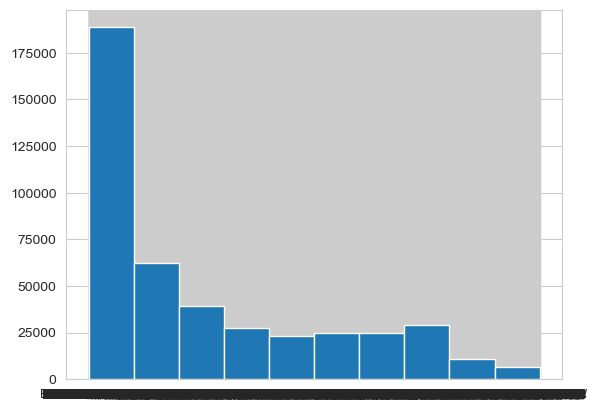

In [214]:
full_merged_df['item'].hist()

<BarContainer object of 12102 artists>

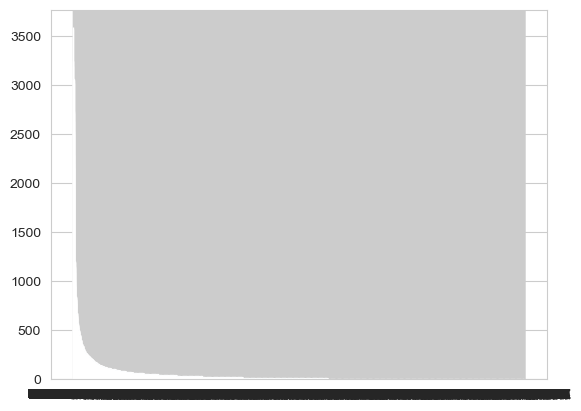

In [540]:
plt.bar(full_merged_df['item'].value_counts().index.tolist(), full_merged_df['item'].value_counts())

In [228]:
# Вывод списка покупателей и количество покупок
full_merged_df.groupby('user')['item'].count()

user
A0002708WFPIPQT73GK8    1
A0026756LXIAIU5P6JUI    1
A0036810AKGSUKHOLV23    1
A004163085WKABQBPDOX    1
A00603384WJS45MGZ9ZV    1
                       ..
AZZYUA6JI1MO0           2
AZZYW4YOE1B6E           3
AZZZ27Q95ZU80           1
AZZZ3LGTCGUZF           1
AZZZYAYJQSDOJ           1
Name: item, Length: 338963, dtype: int64

<AxesSubplot: >

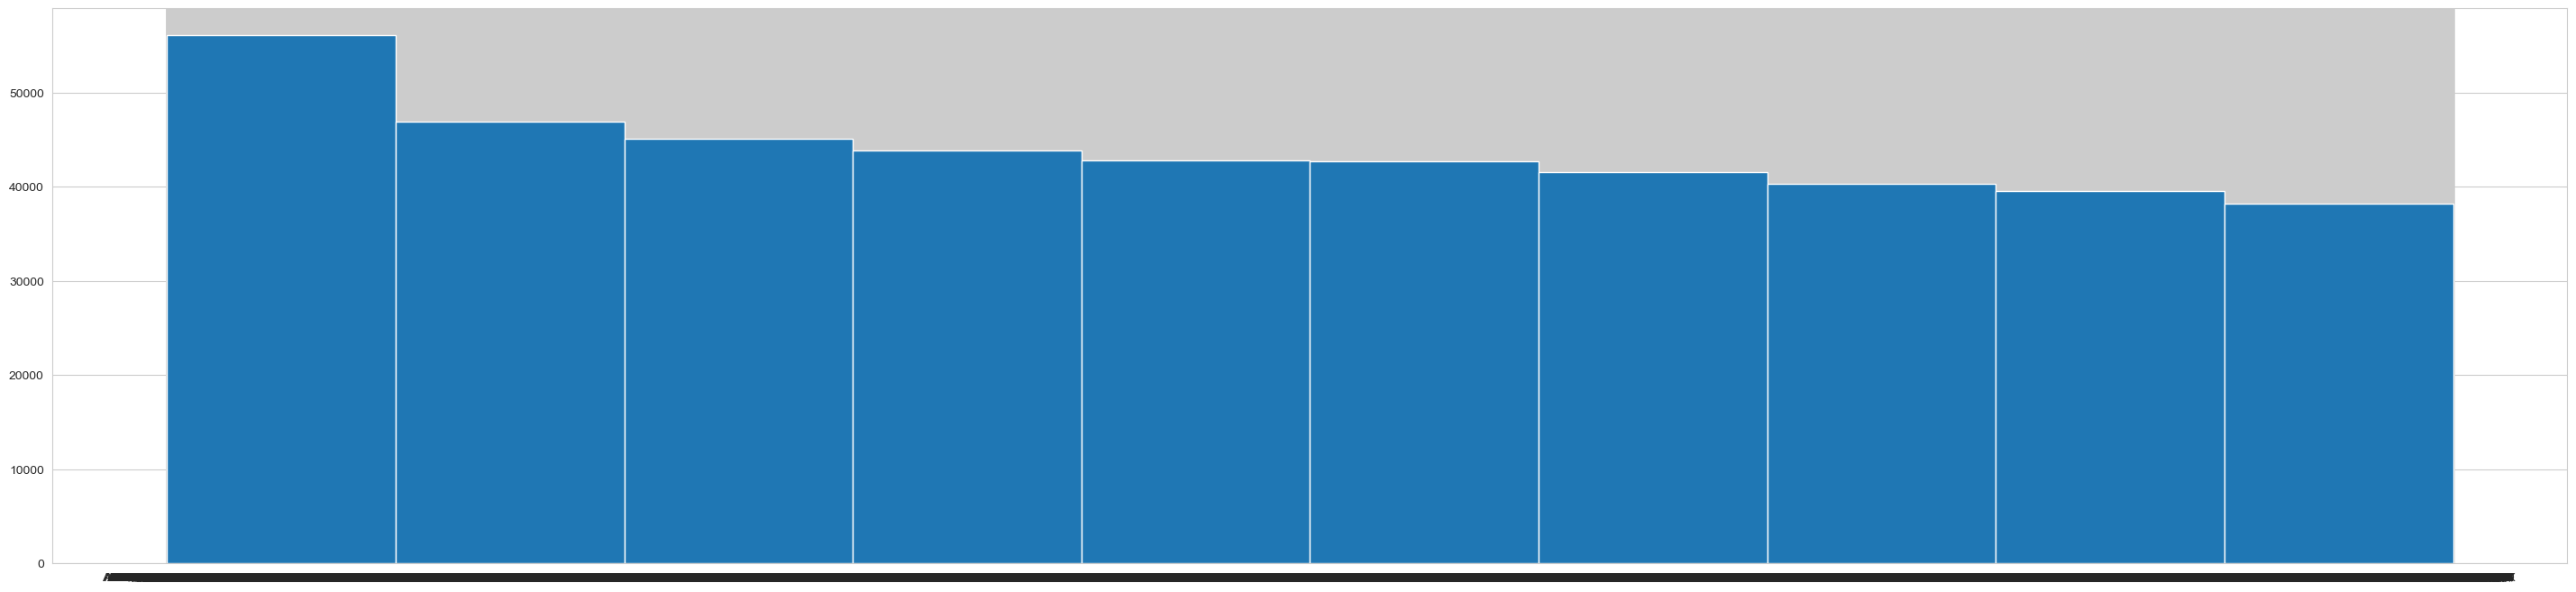

In [216]:
full_merged_df['user'].hist( figsize=(36,8)) # особо ничего не показал

In [217]:
# посмотрим какие оценки ставили пользователи в каком количестве
full_merged_df.rating.value_counts()

5.0    291397
4.0     51873
1.0     39559
3.0     31761
2.0     22389
Name: rating, dtype: int64

<BarContainer object of 5 artists>

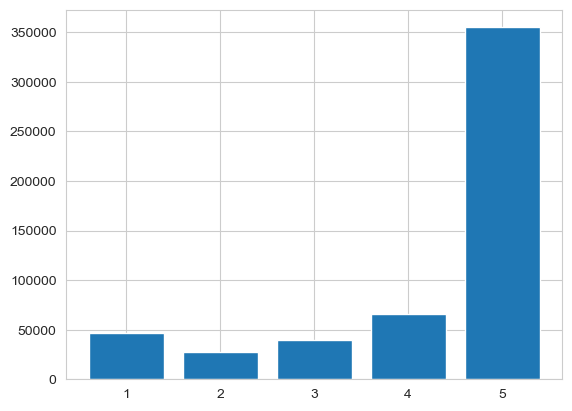

In [270]:
plt.bar(full_merged_df['rating'].value_counts().index.tolist(), full_merged_df['rating'].value_counts())

In [271]:
user_purchase_counts = full_merged_df.groupby('user')['item'].count()

In [272]:
user_purchase_counts

user
A0002708WFPIPQT73GK8    1
A0010876CNE3ILIM9HV0    1
A0026756LXIAIU5P6JUI    1
A0036810AKGSUKHOLV23    1
A004163085WKABQBPDOX    1
                       ..
AZZYUA6JI1MO0           2
AZZYW4YOE1B6E           3
AZZZ27Q95ZU80           1
AZZZ3LGTCGUZF           1
AZZZYAYJQSDOJ           1
Name: item, Length: 409698, dtype: int64

In [498]:
users_with_more_than_10_purchases = user_purchase_counts[user_purchase_counts >= 5].index

In [499]:
users_with_more_than_10_purchases

Index(['A0067293ETUPO6WG7DKU', 'A0488385844WNV2OWO9X', 'A0505999GY3IIQK03WD1',
       'A0955928C2RRWOWZN7UC', 'A0976794S8VOYNT78YEM', 'A1004703RC79J9',
       'A100WO06OQR8BQ', 'A100ZQDV7L8PVV', 'A102300ZYSDHRR', 'A102866V814SOJ',
       ...
       'AZQKNX6F8S84Q', 'AZS23E3IKSF9D', 'AZSYHIK3A3KWE', 'AZUM88P0Q6626',
       'AZWXG6KBXXC2N', 'AZY31SPDXGJQ', 'AZYAFW3CRARM6', 'AZYJE40XW6MFG',
       'AZZ5ASC403N74', 'AZZGGWZV5VR74'],
      dtype='object', name='user', length=4952)

In [500]:
df_filtered = full_merged_df[full_merged_df['user'].isin(users_with_more_than_10_purchases)]

In [501]:
df_filtered = df_filtered.drop_duplicates(['item', 'user'])

In [502]:
df_filtered

,item,user,rating,timestamp,date_time,reviewText,summary,title,description,price
134,B00004U9V2,A2HOI48JK8838M,5.0,1515110400,2018-01-05,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,['After a long day of handling thorny situatio...,$30.00
252,B00004U9V2,AZY31SPDXGJQ,5.0,1496534400,2017-06-04,NaN,NaN,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,['After a long day of handling thorny situatio...,$30.00
302,B00004U9V2,A1YIPEY7HX73S7,5.0,1491350400,2017-04-05,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,['After a long day of handling thorny situatio...,$30.00
314,B00004U9V2,A2QCGHIJ2TCLVP,5.0,1490572800,2017-03-27,"Best hand cream around. Silky, thick, soaks i...",Best hand cream around,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,['After a long day of handling thorny situatio...,$30.00
334,B00004U9V2,A2R4UNHFJBA6PY,5.0,1489968000,2017-03-20,Thanks!!,Five Stars,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,['After a long day of handling thorny situatio...,$30.00
...,...,...,...,...,...,...,...,...,...,...
561998,B01HIIO7Q4,AY8WT4WMDDUX0,3.0,1485907200,2017-02-01,NaN,NaN,Klorane Conditioner with Pomegranate - Color-T...,"['With a color-enhancing complex, this conditi...",$20.00
562005,B01HIQHQU0,A3SMY3BN9PMDK6,5.0,1491004800,2017-04-01,NaN,NaN,CND Shellac power polish denim patch,['CND Shellac was designed to be used as a sys...,$15.95
562015,B01HIQIEYC,AKP89K0R96VWB,5.0,1500249600,2017-07-17,NaN,NaN,"CND Shellac Power Polish, Patina Buckle","['', 'CND Craft Culture Collection: Patina Buc...",$15.95
562017,B01HIQCSBC,A3IRO9Y2W7DGXU,5.0,1492387200,2017-04-17,NaN,NaN,"CND Shellac, Brick Knit",['CND Shellac was designed to be used as a sys...,NaN


In [542]:
df_filtered.to_csv('df_filtered.csv', index=False) # save dataset

In [491]:
rmse = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))

def train_test_split(X, ratio=0.2, user_col='userId', item_col='movieId',
                     rating_col='rating', time_col='timestamp'):
    '''
    :param X: данные
    :param ratio: доля данных, которые мы откладываем в тест
    :param user_col: название колонок, содержащие информацию о юзерах\айтемах и т.д.
    :param item_col:
    :param rating_col:
    :param time_col:
    :return:
    '''
    # сортируем оценки по времени
    X.sort_values(by=[time_col], inplace=True)
    # список всех юзеров
    userIds = X[user_col].unique()

    X_train_data = []
    X_test_data = []
    y_train = []
    y_test = []

    for userId in tqdm_notebook(userIds):
        curUser = X[X[user_col] == userId]
        # определяем позицию, по которой делим выборку и размещаем данные по массивам
        idx = int(curUser.shape[0] * (1 - ratio)) # смотрим, сколько для каждого юзера нужно отложить фильмов в тест
        X_train_data.append(curUser[[user_col, item_col]].iloc[:idx, :].values)
        X_test_data.append(curUser[[user_col, item_col]].iloc[idx:, :].values)
        y_train.append(curUser[rating_col].values[:idx])
        y_test.append(curUser[rating_col].values[idx:])
    # cтекуем данные по каждому пользователю в общие массивы
    X_train = pd.DataFrame(np.vstack(X_train_data), columns=[user_col, item_col])
    X_test = pd.DataFrame(np.vstack(X_test_data), columns=[user_col, item_col])
    y_train = np.hstack(y_train)
    y_test = np.hstack(y_test)
    return X_train, X_test, y_train, y_test

In [503]:
X_train, X_test, y_train, y_test = train_test_split(df_filtered, user_col='user', item_col='item') #merged_df[merged_df['summary'].notna()]

  0%|          | 0/4952 [00:00<?, ?it/s]

In [493]:
X_train.shape, len(y_train), X_test.shape, len(y_test)

((19354, 2), 19354, (6088, 2), 6088)

# Collaborative filtering

# Item-based model
**Item-based model** очень похожа на предыдущую модель по структуре, но теперь мы ищем похожие товары, а не пользователей.

In [285]:
class ItemBased(BaseEstimator):
    def fit(self, X, y, user_col='user', item_col='item'):
        X = X.copy()
        # сохраним текущих пользователей и имеющиеся предметы
        self.users = X[user_col].unique()
        self.items = X[item_col].unique()
        
        X['y'] = y
        # рассчитаем среднее значение рейтинга для пользователя и предмета
        self.mean_y_user = X.groupby(user_col)['y'].mean()
        self.mean_y_item = X.groupby(item_col)['y'].mean()
        
        # вычитаем среднюю оценку предмета
        X['y'] -= X[item_col].apply(lambda x: self.mean_y_item[x])
        
        # создаём векторы для каждого фильма с оценками пользователя
        # если пользователь не поставил оценку, то ставим 0
        self.item_ratings = pd.pivot_table(X, values='y', index=item_col,
                                           columns=user_col, fill_value=0)
        
        # считаем попарную схожесть между фильмами
        self.item_sim = cosine_similarity(self.item_ratings)
        
        # также сделаем словарь {значение item_col: index в item_ratings}
        self.item_pos = dict()
        for item in self.items:
            self.item_pos[item] = np.argwhere(self.item_ratings.index.values == item)[0][0]
        return self
    
    def predict_rating(self, pr_user, pr_item):
        # если в обучающей выборке нет такого предмета
        # или пользователя, то вернём 0
        if not pr_item in self.items or not pr_user in self.users:
            return 0
        
        # считаем числитель и знаменатель дроби из формулы предсказания
        numerator = self.item_sim[self.item_pos[pr_item]].dot(
                        self.item_ratings.loc[:, pr_user])   
        # вычитаем 1, так как схожесть предмета с самим собой равна 1,
        # но модель не должна это учитывать
        denominator = np.abs(self.item_sim[self.item_pos[pr_item]]).sum() - 1
        
        return self.mean_y_item[pr_item] + numerator / denominator
    
    def predict(self, X, user_col='user', item_col='item'):
        y = X[[user_col, item_col]].apply(lambda row: self.predict_rating(row[0], row[1]), axis=1)
        return y

In [516]:
%%time
print('start fitting...')
ib = ItemBased().fit(X_train, y_train)

start fitting...
Wall time: 3.19 s


In [517]:

print('start predicting...')
print('rmse = {}'.format(rmse(y_test, ib.predict(X_test))))

start predicting...
rmse = 1.7497295853047443


тут либо меньше фильтровать датасет и получить очень разряженную матрицу с большими ошибками, либо применять отсев по количеству покупок на одного пользователя >= 5 и выше, но тогда не работает UserBased подход (или NaN вылезают, или ошибка кабсурдно высокая получается)